# **Feladatleírás**

A projekt során egy felügyelt gépi tanulási problémát oldunk meg egy általunk tetszőlegesen választott adatbázison. A munkához egy banki adatbázist választottunk, amiben a bank az ügyfeleiről tárol el különféle adatokat. Ezek alapján azt szeretnénk megjósolni, hogy egy új ügyfél a jövőben fog-e betéti számlát nyitni.

# **Importok**

In [1]:
import os
from zipfile import ZipFile
import urllib.request
import pandas as pd
import numpy as np
from sklearn import datasets
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.dummy import DummyClassifier
from sklearn.metrics import (accuracy_score, balanced_accuracy_score,
recall_score, precision_score, f1_score, brier_score_loss)
from scipy.stats import binom_test
from sklearn.naive_bayes import GaussianNB
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import NearestCentroid, KNeighborsClassifier

# **Paraméterek**

In [2]:
str_labels = ['job', 'marital', 'education', 'default', 'housing', 'loan']
int_labels = ['age', 'balance']
labels = str_labels + int_labels

empty_drop = True

train_size = 0.7
dev_size = 0.15
test_size = 1 - train_size - dev_size

# **Dataset**

Az adatokat egy linkből importáltuk be. Az így elért adatokat kicsomagoltuk és betöltöttük.

In [3]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank.zip'
urllib.request.urlretrieve(url, './bank.zip') 
with ZipFile('bank.zip', "r") as zipObj:
    zipObj.extractall()

bankdata_full = pd.read_csv("./bank-full.csv", delimiter=';')
# Tesztelesbol kiirjuk a beolvasott .csv fajl egyes reszeit
print("Adatrekordok szama: " + str(len(bankdata_full.index)))
print(np.sort((bankdata_full['age'].unique())))

Adatrekordok szama: 45211
[18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41
 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65
 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89
 90 92 93 94 95]


# **Adatfeldolgozás (MK - I)**

Megnéztük, hogy mennyi olyan sorunk van az adathalmazban, amiben van üres cella.

In [4]:
for label in labels:
    i = 0
    for l in bankdata_full[label]:
        if l == "unknown":
            i += 1
    print(label + ": " + str(i))

job: 288
marital: 0
education: 1857
default: 0
housing: 0
loan: 0
age: 0
balance: 0


Majd ezeket kitöröltük.

In [5]:
if empty_drop:
    for label in labels:
        for l in bankdata_full[label]:
            if l == "unknown":
                bankdata_dropped = bankdata_full.drop(bankdata_full.loc[bankdata_full[label] == "unknown"].index, inplace=False)
    print(bankdata_dropped)
else:
    pass
    # TODO: eldobás helyett valami más módszer az üres cellát tartalmazó sorok kezelésére

       age           job   marital  education default  balance housing loan  \
0       58    management   married   tertiary      no     2143     yes   no   
1       44    technician    single  secondary      no       29     yes   no   
2       33  entrepreneur   married  secondary      no        2     yes  yes   
5       35    management   married   tertiary      no      231     yes   no   
6       28    management    single   tertiary      no      447     yes  yes   
...    ...           ...       ...        ...     ...      ...     ...  ...   
45206   51    technician   married   tertiary      no      825      no   no   
45207   71       retired  divorced    primary      no     1729      no   no   
45208   72       retired   married  secondary      no     5715      no   no   
45209   57   blue-collar   married  secondary      no      668      no   no   
45210   37  entrepreneur   married  secondary      no     2971      no   no   

         contact  day month  duration  campaign  pd

In [6]:
bankdata_dropped['loan'].value_counts()

no     36243
yes     7111
Name: loan, dtype: int64

**Ordial Encoder**

In [7]:
encoded_str = bankdata_dropped[str_labels]

oe = preprocessing.OrdinalEncoder()
encoded_str[str_labels] = oe.fit_transform(encoded_str[str_labels])

print(encoded_str)

       job  marital  education  default  housing  loan
0      4.0      1.0        2.0      0.0      1.0   0.0
1      9.0      2.0        1.0      0.0      1.0   0.0
2      2.0      1.0        1.0      0.0      1.0   1.0
5      4.0      1.0        2.0      0.0      1.0   0.0
6      4.0      2.0        2.0      0.0      1.0   1.0
...    ...      ...        ...      ...      ...   ...
45206  9.0      1.0        2.0      0.0      0.0   0.0
45207  5.0      0.0        0.0      0.0      0.0   0.0
45208  5.0      1.0        1.0      0.0      0.0   0.0
45209  1.0      1.0        1.0      0.0      0.0   0.0
45210  2.0      1.0        1.0      0.0      0.0   0.0

[43354 rows x 6 columns]


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


**MinMax Scaler**

In [8]:
min_max_scaler = preprocessing.MinMaxScaler()
encoded_str[str_labels] = min_max_scaler.fit_transform(encoded_str[str_labels])

print(encoded_str)

            job  marital  education  default  housing  loan
0      0.363636      0.5        1.0      0.0      1.0   0.0
1      0.818182      1.0        0.5      0.0      1.0   0.0
2      0.181818      0.5        0.5      0.0      1.0   1.0
5      0.363636      0.5        1.0      0.0      1.0   0.0
6      0.363636      1.0        1.0      0.0      1.0   1.0
...         ...      ...        ...      ...      ...   ...
45206  0.818182      0.5        1.0      0.0      0.0   0.0
45207  0.454545      0.0        0.0      0.0      0.0   0.0
45208  0.454545      0.5        0.5      0.0      0.0   0.0
45209  0.090909      0.5        0.5      0.0      0.0   0.0
45210  0.181818      0.5        0.5      0.0      0.0   0.0

[43354 rows x 6 columns]


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


**Standard Scaler**

In [9]:
encoded_int = bankdata_dropped[int_labels]

ss = preprocessing.StandardScaler()
encoded_int[int_labels] = ss.fit_transform(encoded_int[int_labels])

print(encoded_int)

            age   balance
0      1.636763  0.259146
1      0.305821 -0.436276
2     -0.739919 -0.445158
5     -0.549785 -0.369826
6     -1.215256 -0.298770
...         ...       ...
45206  0.971292 -0.174423
45207  2.872638  0.122957
45208  2.967705  1.434192
45209  1.541696 -0.226070
45210 -0.359650  0.531525

[43354 rows x 2 columns]


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


**Ellenőrzésképp átlag és szórás kiszámolása**

In [10]:
print(np.mean(encoded_int['age'],axis=0))
print(np.std(encoded_int['age'],axis=0))

-1.1595856186710912e-15
1.0000000000000047


**Elkészült adatoszlopok összefűzése**

In [11]:
encoded_full = pd.concat([encoded_str, encoded_int], axis=1)
print(encoded_full)

            job  marital  education  default  housing  loan       age  \
0      0.363636      0.5        1.0      0.0      1.0   0.0  1.636763   
1      0.818182      1.0        0.5      0.0      1.0   0.0  0.305821   
2      0.181818      0.5        0.5      0.0      1.0   1.0 -0.739919   
5      0.363636      0.5        1.0      0.0      1.0   0.0 -0.549785   
6      0.363636      1.0        1.0      0.0      1.0   1.0 -1.215256   
...         ...      ...        ...      ...      ...   ...       ...   
45206  0.818182      0.5        1.0      0.0      0.0   0.0  0.971292   
45207  0.454545      0.0        0.0      0.0      0.0   0.0  2.872638   
45208  0.454545      0.5        0.5      0.0      0.0   0.0  2.967705   
45209  0.090909      0.5        0.5      0.0      0.0   0.0  1.541696   
45210  0.181818      0.5        0.5      0.0      0.0   0.0 -0.359650   

        balance  
0      0.259146  
1     -0.436276  
2     -0.445158  
5     -0.369826  
6     -0.298770  
...         ...

**Adathalmaz felosztása**

In [12]:
train, dev, test = np.split(encoded_full.sample(frac=1, random_state=123456),
                            [int(train_size*len(encoded_full)), int((train_size+dev_size)*len(encoded_full))])
print("Train size: " + str(train.size // 8))
print("Dev size: " + str(dev.size // 8))
print("Test size: " + str(test.size // 8))

Train size: 30347
Dev size: 6503
Test size: 6504


In [13]:
x_train = train.drop(columns=['loan'])
y_train = train['loan']

x_dev = dev.drop(columns=['loan'])
y_dev = dev['loan']

x_test = test.drop(columns=['loan'])
y_test = test['loan']

# **Modellezés (MK - II)**

**Kiértékelő függvények a tanító és a teszt halmazra, amikben különböző metrikákkal vizsgálhatjuk tanításaink sikerességét**

In [14]:
def evaluate_train():

    print(y_train.value_counts(), "\n")
    unique, counts = np.unique(pred_train, return_counts=True)

    print(dict(zip(unique, counts)),  "\n")

    test_accuracy_score = accuracy_score(y_train, pred_train)
    print('train - accuracy_score: ', test_accuracy_score)

    '''
    n_success = np.sum(y_test == pred)
    p = 0.90
    interval = binom_test(n_success, y_test.shape[0], p=p)
    print("Test-acc: ", acc, "+/-", interval, "(", p*100, "%)")
    '''

    test_balanced_accuracy_score = balanced_accuracy_score(y_train, pred_train)
    print('train - balanced_accuracy_score: ', test_balanced_accuracy_score)

    test_recall_score = recall_score(y_train, pred_train)
    print('train - recall_score: ', test_recall_score)

    test_precision_score = precision_score(y_train, pred_train, zero_division=0)
    print('train - preision_score: ', test_precision_score)

    test_f1_score = f1_score(y_train, pred_train)
    print('train - f1_score: ', test_f1_score)

    test_brier_score_loss = brier_score_loss(y_train, pred_train)
    print('train - brier_score_loss: ', test_brier_score_loss)

    print()

In [15]:
def evaluate_test():

    print(y_test.value_counts(), "\n")
    unique, counts = np.unique(pred_test, return_counts=True)

    print(dict(zip(unique, counts)),  "\n")

    test_accuracy_score = accuracy_score(y_test, pred_test)
    print('test - accuracy_score: ', test_accuracy_score)

    '''
    n_success = np.sum(y_test == pred)
    p = 0.90
    interval = binom_test(n_success, y_test.shape[0], p=p)
    print("Test-acc: ", acc, "+/-", interval, "(", p*100, "%)")
    '''

    test_balanced_accuracy_score = balanced_accuracy_score(y_test, pred_test)
    print('test - balanced_accuracy_score: ', test_balanced_accuracy_score)

    test_recall_score = recall_score(y_test, pred_test)
    print('test - recall_score: ', test_recall_score)

    test_precision_score = precision_score(y_test, pred_test, zero_division=0)
    print('test - preision_score: ', test_precision_score)

    test_f1_score = f1_score(y_test, pred_test)
    print('test - f1_score: ', test_f1_score)

    test_brier_score_loss = brier_score_loss(y_test, pred_test)
    print('test - brier_score_loss: ', test_brier_score_loss)

    print()

**Baseline (Constant)**

In [16]:
base_line = DummyClassifier(strategy='constant', constant=1.0)
base_line.fit(x_train, y_train)

pred_train = base_line.predict(train)
pred_test = base_line.predict(test)

evaluate_train()
evaluate_test()

0.0    25386
1.0     4961
Name: loan, dtype: int64 

{1.0: 30347} 

train - accuracy_score:  0.1634757966191057
train - balanced_accuracy_score:  0.5
train - recall_score:  1.0
train - preision_score:  0.1634757966191057
train - f1_score:  0.2810128016313584
train - brier_score_loss:  0.8365242033808943

0.0    5448
1.0    1056
Name: loan, dtype: int64 

{1.0: 6504} 

test - accuracy_score:  0.16236162361623616
test - balanced_accuracy_score:  0.5
test - recall_score:  1.0
test - preision_score:  0.16236162361623616
test - f1_score:  0.27936507936507937
test - brier_score_loss:  0.8376383763837638



**Baseline (Random)**

In [17]:
pred_train = np.random.randint(0, 2, size=(1, len(y_train)))[0]
pred_test = np.random.randint(0, 2, size=(1, len(y_test)))[0]

evaluate_train()
evaluate_test()

0.0    25386
1.0     4961
Name: loan, dtype: int64 

{0: 15292, 1: 15055} 

train - accuracy_score:  0.5015652288529344
train - balanced_accuracy_score:  0.4980568516362553
train - recall_score:  0.49284418464019353
train - preision_score:  0.1624045167718366
train - f1_score:  0.2443045563549161
train - brier_score_loss:  0.4984347711470656

0.0    5448
1.0    1056
Name: loan, dtype: int64 

{0: 3284, 1: 3220} 

test - accuracy_score:  0.506150061500615
test - balanced_accuracy_score:  0.5051979041516487
test - recall_score:  0.5037878787878788
test - preision_score:  0.16521739130434782
test - f1_score:  0.24883068288119736
test - brier_score_loss:  0.49384993849938497



**Baseline (Random with given distribution)**

In [18]:
pred_train = np.random.choice(2, len(pred_train), p=[0.83, 0.17])
pred_test = np.random.choice(2, len(pred_test), p=[0.83, 0.17])

evaluate_train()
evaluate_test()

0.0    25386
1.0     4961
Name: loan, dtype: int64 

{0: 25181, 1: 5166} 

train - accuracy_score:  0.7221142122779847
train - balanced_accuracy_score:  0.5002992815321677
train - recall_score:  0.17073170731707318
train - preision_score:  0.16395663956639567
train - f1_score:  0.16727559988150492
train - brier_score_loss:  0.27788578772201533

0.0    5448
1.0    1056
Name: loan, dtype: int64 

{0: 5365, 1: 1139} 

test - accuracy_score:  0.7230934809348093
test - balanced_accuracy_score:  0.5068227706581231
test - recall_score:  0.1865530303030303
test - preision_score:  0.17295873573309922
test - f1_score:  0.179498861047836
test - brier_score_loss:  0.27690651906519065



**Baseline (Most Frequent)**

In [19]:
base_line = DummyClassifier(strategy='most_frequent')
base_line.fit(x_train, y_train)

pred_train = base_line.predict(train)
pred_test = base_line.predict(test)

evaluate_train()
evaluate_test()

0.0    25386
1.0     4961
Name: loan, dtype: int64 

{0.0: 30347} 

train - accuracy_score:  0.8365242033808943
train - balanced_accuracy_score:  0.5
train - recall_score:  0.0
train - preision_score:  0.0
train - f1_score:  0.0
train - brier_score_loss:  0.1634757966191057

0.0    5448
1.0    1056
Name: loan, dtype: int64 

{0.0: 6504} 

test - accuracy_score:  0.8376383763837638
test - balanced_accuracy_score:  0.5
test - recall_score:  0.0
test - preision_score:  0.0
test - f1_score:  0.0
test - brier_score_loss:  0.16236162361623616



**Gaussian Naive-Bayes**

In [20]:
model = GaussianNB()
model.fit(x_train, y_train)

pred_train = model.predict(x_train)
pred_test = model.predict(x_test)

evaluate_train()
evaluate_test()

0.0    25386
1.0     4961
Name: loan, dtype: int64 

{0.0: 29792, 1.0: 555} 

train - accuracy_score:  0.8322733713381882
train - balanced_accuracy_score:  0.5147314498610314
train - recall_score:  0.042934892158838944
train - preision_score:  0.3837837837837838
train - f1_score:  0.0772298767222625
train - brier_score_loss:  0.1677266286618117

0.0    5448
1.0    1056
Name: loan, dtype: int64 

{0.0: 6385, 1.0: 119} 

test - accuracy_score:  0.8322570725707257
test - balanced_accuracy_score:  0.5128195501268188
test - recall_score:  0.03977272727272727
test - preision_score:  0.35294117647058826
test - f1_score:  0.07148936170212765
test - brier_score_loss:  0.1677429274292743



**Gaussian Mixture Model**

In [21]:
def make_prediction(gmms, x):
    n_samples = x.shape[0]
    p_test = np.zeros(n_samples)
    for i in range(n_samples):
        pred_val = -np.inf
        for c_idx in range(len(gmms)):
            dense_val = gmms[c_idx].score(x[i:(i+1)])
            if dense_val > pred_val:
                p_test[i]=c_idx
                pred_val=dense_val
    return p_test

#cov_type = 'spherical'
#cov_type = 'full'
#cov_type = 'diag'
cov_type = 'tied'
n_components = 1
gmm_models = {0:GaussianMixture(n_components=n_components, covariance_type=cov_type),
              1:GaussianMixture(n_components=n_components, covariance_type=cov_type)}

for (c_idx, model) in gmm_models.items():
    #print(x_train[y_train == c_idx].shape)
    model.fit(x_train[y_train == c_idx])

pred_train = make_prediction(gmm_models, x_train)
#print('train_acc: ', accuracy_score(y_train, pred_train))
pred_test = make_prediction(gmm_models, x_test)
#print('test_acc: ', accuracy_score(y_test, pred_test))

evaluate_train()
evaluate_test()

0.0    25386
1.0     4961
Name: loan, dtype: int64 

{0.0: 20176, 1.0: 10171} 

train - accuracy_score:  0.6507068243977988
train - balanced_accuracy_score:  0.5726853217802714
train - recall_score:  0.4567627494456763
train - preision_score:  0.22279028610756071
train - f1_score:  0.2994977531060006
train - brier_score_loss:  0.3492931756022012

0.0    5448
1.0    1056
Name: loan, dtype: int64 

{0.0: 4354, 1.0: 2150} 

test - accuracy_score:  0.6420664206642066
test - balanced_accuracy_score:  0.5508297456948338
test - recall_score:  0.41571969696969696
test - preision_score:  0.20418604651162792
test - f1_score:  0.27386150966936995
test - brier_score_loss:  0.35793357933579334



**K Nearest Neighbour**

In [22]:
k = 2
knn = KNeighborsClassifier(n_neighbors = k)

knn.fit(x_train, y_train)

pred_train = knn.predict(x_train)
pred_test = knn.predict(x_test)

evaluate_train()
evaluate_test()

0.0    25386
1.0     4961
Name: loan, dtype: int64 

{0.0: 29063, 1.0: 1284} 

train - accuracy_score:  0.8787030019441789
train - balanced_accuracy_score:  0.629168429213079
train - recall_score:  0.25841564200765976
train - preision_score:  0.9984423676012462
train - f1_score:  0.4105684547638111
train - brier_score_loss:  0.121296998055821

0.0    5448
1.0    1056
Name: loan, dtype: int64 

{0.0: 6276, 1.0: 228} 

test - accuracy_score:  0.826260762607626
test - balanced_accuracy_score:  0.5226000367107195
test - recall_score:  0.07291666666666667
test - preision_score:  0.33771929824561403
test - f1_score:  0.11993769470404986
test - brier_score_loss:  0.17373923739237393



**GridSearch a legjobb szomszédsági szám megtalálásához**

In [23]:
tuned_parameters = [{'n_neighbors': range(21)}]
scoring='accuracy'
base_model = KNeighborsClassifier()
clf = GridSearchCV(base_model, tuned_parameters, cv=5, scoring=scoring,
                   return_train_score=True, refit=True)
clf.fit(x_train, y_train)
print("Best parameters set found on development set:\n")
print(clf.best_params_)
print("\nGrid scores on development set:\n")
val_means = clf.cv_results_['mean_test_score']
val_stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(val_means, val_stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))

Best parameters set found on development set:

{'n_neighbors': 20}

Grid scores on development set:

nan (+/-nan) for {'n_neighbors': 0}
0.758 (+/-0.006) for {'n_neighbors': 1}
0.821 (+/-0.004) for {'n_neighbors': 2}
0.794 (+/-0.004) for {'n_neighbors': 3}
0.826 (+/-0.005) for {'n_neighbors': 4}
0.815 (+/-0.003) for {'n_neighbors': 5}
0.830 (+/-0.003) for {'n_neighbors': 6}
0.824 (+/-0.003) for {'n_neighbors': 7}
0.832 (+/-0.002) for {'n_neighbors': 8}
0.828 (+/-0.003) for {'n_neighbors': 9}
0.834 (+/-0.001) for {'n_neighbors': 10}
0.831 (+/-0.003) for {'n_neighbors': 11}
0.835 (+/-0.003) for {'n_neighbors': 12}
0.833 (+/-0.004) for {'n_neighbors': 13}
0.835 (+/-0.002) for {'n_neighbors': 14}
0.835 (+/-0.003) for {'n_neighbors': 15}
0.836 (+/-0.002) for {'n_neighbors': 16}
0.835 (+/-0.003) for {'n_neighbors': 17}
0.836 (+/-0.001) for {'n_neighbors': 18}
0.835 (+/-0.002) for {'n_neighbors': 19}
0.836 (+/-0.001) for {'n_neighbors': 20}


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 105.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py", line 198, in fit
    return self._fit(X, y)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_base.py", line 569, in _fit
    raise ValueError("Expected n_neighbors > 0. Got %d" % self.n_neighbors)
ValueError: Expecte

**Nearest Centroid**

In [24]:
nc = NearestCentroid()
nc.fit(x_train, y_train)

pred_train = nc.predict(x_train)
pred_test = nc.predict(x_test)

evaluate_train()
evaluate_test()

0.0    25386
1.0     4961
Name: loan, dtype: int64 

{0.0: 10661, 1.0: 19686} 

train - accuracy_score:  0.4352324776748937
train - balanced_accuracy_score:  0.5645561337623568
train - recall_score:  0.7567022777665793
train - preision_score:  0.19069389413796606
train - f1_score:  0.3046212520793605
train - brier_score_loss:  0.5647675223251063

0.0    5448
1.0    1056
Name: loan, dtype: int64 

{0.0: 2293, 1.0: 4211} 

test - accuracy_score:  0.43219557195571956
test - balanced_accuracy_score:  0.5583888165798958
test - recall_score:  0.7452651515151515
test - preision_score:  0.18689147470909523
test - f1_score:  0.29884184545281944
test - brier_score_loss:  0.5678044280442804



# **További fejlesztések (MK - III)**

## **Feature selection használata**

In [25]:
str_labels = ['job', 'marital', 'education', 'default', 'housing', 'loan',
              'contact', 'month', 'poutcome']
int_labels = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays',
              'previous']
labels = str_labels + int_labels

In [26]:
for label in labels:
    i = 0
    for l in bankdata_full[label]:
        if l == "unknown":
            i += 1
    print(label + ": " + str(i))

job: 288
marital: 0
education: 1857
default: 0
housing: 0
loan: 0
contact: 13020
month: 0
poutcome: 36959
age: 0
balance: 0
day: 0
duration: 0
campaign: 0
pdays: 0
previous: 0


In [27]:
encoded_str = bankdata_dropped[str_labels]

oe = preprocessing.OrdinalEncoder()
encoded_str[str_labels] = oe.fit_transform(encoded_str[str_labels])

print(encoded_str)

       job  marital  education  default  housing  loan  contact  month  \
0      4.0      1.0        2.0      0.0      1.0   0.0      2.0    8.0   
1      9.0      2.0        1.0      0.0      1.0   0.0      2.0    8.0   
2      2.0      1.0        1.0      0.0      1.0   1.0      2.0    8.0   
5      4.0      1.0        2.0      0.0      1.0   0.0      2.0    8.0   
6      4.0      2.0        2.0      0.0      1.0   1.0      2.0    8.0   
...    ...      ...        ...      ...      ...   ...      ...    ...   
45206  9.0      1.0        2.0      0.0      0.0   0.0      0.0    9.0   
45207  5.0      0.0        0.0      0.0      0.0   0.0      0.0    9.0   
45208  5.0      1.0        1.0      0.0      0.0   0.0      0.0    9.0   
45209  1.0      1.0        1.0      0.0      0.0   0.0      1.0    9.0   
45210  2.0      1.0        1.0      0.0      0.0   0.0      0.0    9.0   

       poutcome  
0           3.0  
1           3.0  
2           3.0  
5           3.0  
6           3.0  
...

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


In [28]:
min_max_scaler = preprocessing.MinMaxScaler()
encoded_str[str_labels] = min_max_scaler.fit_transform(encoded_str[str_labels])

print(encoded_str)

            job  marital  education  default  housing  loan  contact  \
0      0.363636      0.5        1.0      0.0      1.0   0.0      1.0   
1      0.818182      1.0        0.5      0.0      1.0   0.0      1.0   
2      0.181818      0.5        0.5      0.0      1.0   1.0      1.0   
5      0.363636      0.5        1.0      0.0      1.0   0.0      1.0   
6      0.363636      1.0        1.0      0.0      1.0   1.0      1.0   
...         ...      ...        ...      ...      ...   ...      ...   
45206  0.818182      0.5        1.0      0.0      0.0   0.0      0.0   
45207  0.454545      0.0        0.0      0.0      0.0   0.0      0.0   
45208  0.454545      0.5        0.5      0.0      0.0   0.0      0.0   
45209  0.090909      0.5        0.5      0.0      0.0   0.0      0.5   
45210  0.181818      0.5        0.5      0.0      0.0   0.0      0.0   

          month  poutcome  
0      0.727273  1.000000  
1      0.727273  1.000000  
2      0.727273  1.000000  
5      0.727273  1.0000

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


In [29]:
encoded_int = bankdata_dropped[int_labels]

ss = preprocessing.StandardScaler()
encoded_int[int_labels] = ss.fit_transform(encoded_int[int_labels])

print(encoded_int)

            age   balance       day  duration  campaign     pdays  previous
0      1.636763  0.259146 -1.300952  0.010854 -0.574199 -0.412047 -0.250795
1      0.305821 -0.436276 -1.300952 -0.415461 -0.574199 -0.412047 -0.250795
2     -0.739919 -0.445158 -1.300952 -0.706131 -0.574199 -0.412047 -0.250795
5     -0.549785 -0.369826 -1.300952 -0.461968 -0.574199 -0.412047 -0.250795
6     -1.215256 -0.298770 -1.300952 -0.159672 -0.574199 -0.412047 -0.250795
...         ...       ...       ...       ...       ...       ...       ...
45206  0.971292 -0.174423  0.143718  2.785777  0.078232 -0.412047 -0.250795
45207  2.872638  0.122957  0.143718  0.766594 -0.247983 -0.412047 -0.250795
45208  2.967705  1.434192  0.143718  3.367116  0.730662  1.431854  1.036961
45209  1.541696 -0.226070  0.143718  0.968125  0.404447 -0.412047 -0.250795
45210 -0.359650  0.531525  0.143718  0.398413 -0.247983  1.471722  4.470976

[43354 rows x 7 columns]


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


In [30]:
encoded_full = pd.concat([encoded_str, encoded_int], axis=1)
print(encoded_full)

            job  marital  education  default  housing  loan  contact  \
0      0.363636      0.5        1.0      0.0      1.0   0.0      1.0   
1      0.818182      1.0        0.5      0.0      1.0   0.0      1.0   
2      0.181818      0.5        0.5      0.0      1.0   1.0      1.0   
5      0.363636      0.5        1.0      0.0      1.0   0.0      1.0   
6      0.363636      1.0        1.0      0.0      1.0   1.0      1.0   
...         ...      ...        ...      ...      ...   ...      ...   
45206  0.818182      0.5        1.0      0.0      0.0   0.0      0.0   
45207  0.454545      0.0        0.0      0.0      0.0   0.0      0.0   
45208  0.454545      0.5        0.5      0.0      0.0   0.0      0.0   
45209  0.090909      0.5        0.5      0.0      0.0   0.0      0.5   
45210  0.181818      0.5        0.5      0.0      0.0   0.0      0.0   

          month  poutcome       age   balance       day  duration  campaign  \
0      0.727273  1.000000  1.636763  0.259146 -1.300952 

In [31]:
train_size = 0.7
dev_size = 0.15
test_size = 1 - train_size - dev_size

In [32]:
train, dev, test = np.split(encoded_full.sample(frac=1, random_state=123456),
                            [int(train_size*len(encoded_full)),
                             int((train_size+dev_size)*len(encoded_full))])
print("Train size: " + str(train.size // 16))
print("Dev size: " + str(dev.size // 16))
print("Test size: " + str(test.size // 16))

Train size: 30347
Dev size: 6503
Test size: 6504


In [33]:
x_train = train.drop(columns=['loan'])
y_train = train['loan']

x_dev = dev.drop(columns=['loan'])
y_dev = dev['loan']

x_test = test.drop(columns=['loan'])
y_test = test['loan']

In [34]:
from sklearn.feature_selection import VarianceThreshold

In [35]:
# range(0.96, 1, 0.05)
vt = VarianceThreshold(threshold = 0.99)
x_filtered = vt.fit_transform(x_train)
df = x_train[x_train.columns[vt.get_support(indices=True)]]
print(df)

columns_to_keep = df.columns
print(columns_to_keep)

            age       day     pdays  previous
40880 -1.025121 -0.458228 -0.412047 -0.250795
34769  0.115686 -1.180563 -0.412047 -0.250795
45194  1.731830  0.023329  1.461755  1.895465
1823  -0.739919 -0.819395 -0.412047 -0.250795
45151  0.591023 -0.819395  3.365458  0.607709
...         ...       ...       ...       ...
9793  -0.549785 -0.819395 -0.412047 -0.250795
34720 -0.359650 -1.300952  3.096348  4.470976
15010  0.115686  0.143718 -0.412047 -0.250795
11414  0.971292  0.384496 -0.412047 -0.250795
41428  1.541696 -1.421341  1.162744  1.466213

[30347 rows x 4 columns]
Index(['age', 'day', 'pdays', 'previous'], dtype='object')


In [36]:
x_train = x_filtered
y_train = train['loan']

x_dev = dev[columns_to_keep]
y_dev = dev['loan']

x_test = test[columns_to_keep]
y_test = test['loan']

In [37]:
model = GaussianNB()
model.fit(x_filtered, y_train)

pred_train = model.predict(x_filtered)
pred_test = model.predict(x_test)

evaluate_train()
evaluate_test()

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but GaussianNB was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


0.0    25386
1.0     4961
Name: loan, dtype: int64 

{0.0: 30347} 

train - accuracy_score:  0.8365242033808943
train - balanced_accuracy_score:  0.5
train - recall_score:  0.0
train - preision_score:  0.0
train - f1_score:  0.0
train - brier_score_loss:  0.1634757966191057

0.0    5448
1.0    1056
Name: loan, dtype: int64 

{0.0: 6504} 

test - accuracy_score:  0.8376383763837638
test - balanced_accuracy_score:  0.5
test - recall_score:  0.0
test - preision_score:  0.0
test - f1_score:  0.0
test - brier_score_loss:  0.16236162361623616



In [38]:
k = 20
knn = KNeighborsClassifier(n_neighbors = k)

knn.fit(x_train, y_train)

pred_train = knn.predict(x_train)
pred_test = knn.predict(x_test)

evaluate_train()
evaluate_test()

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


0.0    25386
1.0     4961
Name: loan, dtype: int64 

{0.0: 30346, 1.0: 1} 

train - accuracy_score:  0.8365571555672718
train - balanced_accuracy_score:  0.5001007861318283
train - recall_score:  0.00020157226365652087
train - preision_score:  1.0
train - f1_score:  0.0004030632809351068
train - brier_score_loss:  0.1634428444327281

0.0    5448
1.0    1056
Name: loan, dtype: int64 

{0.0: 6504} 

test - accuracy_score:  0.8376383763837638
test - balanced_accuracy_score:  0.5
test - recall_score:  0.0
test - preision_score:  0.0
test - f1_score:  0.0
test - brier_score_loss:  0.16236162361623616



In [39]:
x_train = train.drop(columns=['loan'])
y_train = train['loan']

x_dev = dev.drop(columns=['loan'])
y_dev = dev['loan']

x_test = test.drop(columns=['loan'])
y_test = test['loan']

In [40]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt

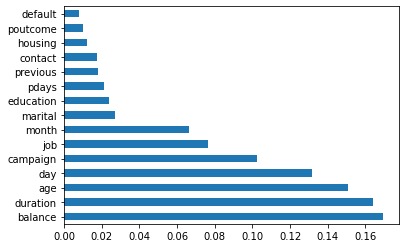

In [41]:
x = x_train
y = y_train
model = ExtraTreesClassifier()
model.fit(x,y)

feat_importances = pd.Series(model.feature_importances_, index=x.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

In [42]:
labels_to_keep = ['balance', 'duration', 'age',
                  'day', 'campaign', 'job', 'month']

In [43]:
x_train = train[labels_to_keep]
y_train = train['loan']

x_dev = dev[labels_to_keep]
y_dev = dev['loan']

x_test = test[labels_to_keep]
y_test = test['loan']

In [44]:
model = GaussianNB()
model.fit(x_train, y_train)

pred_train = model.predict(x_train)
pred_test = model.predict(x_test)

evaluate_train()
evaluate_test()

0.0    25386
1.0     4961
Name: loan, dtype: int64 

{0.0: 29804, 1.0: 543} 

train - accuracy_score:  0.826144264671961
train - balanced_accuracy_score:  0.5030400799123734
train - recall_score:  0.02297923805684338
train - preision_score:  0.20994475138121546
train - f1_score:  0.04142441860465117
train - brier_score_loss:  0.17385573532803902

0.0    5448
1.0    1056
Name: loan, dtype: int64 

{0.0: 6371, 1.0: 133} 

test - accuracy_score:  0.8242619926199262
test - balanced_accuracy_score:  0.5007947036443733
test - recall_score:  0.021780303030303032
test - preision_score:  0.17293233082706766
test - f1_score:  0.038687973086627414
test - brier_score_loss:  0.1757380073800738



In [45]:
k = 20
knn = KNeighborsClassifier(n_neighbors = k)

knn.fit(x_train, y_train)

pred_train = knn.predict(x_train)
pred_test = knn.predict(x_test)

evaluate_train()
evaluate_test()

0.0    25386
1.0     4961
Name: loan, dtype: int64 

{0.0: 30291, 1.0: 56} 

train - accuracy_score:  0.8369855339901803
train - balanced_accuracy_score:  0.5031139008111056
train - recall_score:  0.00705502922797823
train - preision_score:  0.625
train - f1_score:  0.013952561291608531
train - brier_score_loss:  0.16301446600981975

0.0    5448
1.0    1056
Name: loan, dtype: int64 

{0.0: 6492, 1.0: 12} 

test - accuracy_score:  0.8373308733087331
test - balanced_accuracy_score:  0.5017249866506475
test - recall_score:  0.004734848484848485
test - preision_score:  0.4166666666666667
test - f1_score:  0.009363295880149813
test - brier_score_loss:  0.1626691266912669



**Különféle feature selection módszerekkel csökkenteni tudtuk a tanuláshoz felhasznált jellemzők számát, és ennek köszönhetően a betanulási idő is csökkent.**

## **Train-dev-test halmazméretek variálása**

- 50% train
- 25% dev
- 25% test

In [46]:
train_size = 0.5
dev_size = 0.25
test_size = 1 - train_size - dev_size

In [47]:
train, dev, test = np.split(encoded_full.sample(frac=1, random_state=123456),
                            [int(train_size*len(encoded_full)),
                             int((train_size+dev_size)*len(encoded_full))])
print("Train size: " + str(train.size // 16))
print("Dev size: " + str(dev.size // 16))
print("Test size: " + str(test.size // 16))

x_train = train.drop(columns=['loan'])
y_train = train['loan']

x_dev = dev.drop(columns=['loan'])
y_dev = dev['loan']

x_test = test.drop(columns=['loan'])
y_test = test['loan']

Train size: 21677
Dev size: 10838
Test size: 10839


In [48]:
model = GaussianNB()
model.fit(x_train, y_train)

pred_train = model.predict(x_train)
pred_test = model.predict(x_test)

evaluate_train()
evaluate_test()

0.0    18108
1.0     3569
Name: loan, dtype: int64 

{0.0: 20948, 1.0: 729} 

train - accuracy_score:  0.8223923974719749
train - balanced_accuracy_score:  0.5174372262115486
train - recall_score:  0.06276267862146259
train - preision_score:  0.30727023319615915
train - f1_score:  0.10423452768729641
train - brier_score_loss:  0.1776076025280251

0.0    9051
1.0    1788
Name: loan, dtype: int64 

{0.0: 10445, 1.0: 394} 

test - accuracy_score:  0.816957283882277
test - balanced_accuracy_score:  0.5113880219398057
test - recall_score:  0.05536912751677853
test - preision_score:  0.2512690355329949
test - f1_score:  0.09074243813015583
test - brier_score_loss:  0.18304271611772305



In [49]:
k = 20
knn = KNeighborsClassifier(n_neighbors = k)

knn.fit(x_train, y_train)

pred_train = knn.predict(x_train)
pred_test = knn.predict(x_test)

evaluate_train()
evaluate_test()

0.0    18108
1.0     3569
Name: loan, dtype: int64 

{0.0: 21632, 1.0: 45} 

train - accuracy_score:  0.8354938413987175
train - balanced_accuracy_score:  0.5027824321466364
train - recall_score:  0.0067245727094424204
train - preision_score:  0.5333333333333333
train - f1_score:  0.013281682346430549
train - brier_score_loss:  0.16450615860128245

0.0    9051
1.0    1788
Name: loan, dtype: int64 

{0.0: 10810, 1.0: 29} 

test - accuracy_score:  0.8340252790847864
test - balanced_accuracy_score:  0.5014119282307046
test - recall_score:  0.0050335570469798654
test - preision_score:  0.3103448275862069
test - f1_score:  0.009906439185470555
test - brier_score_loss:  0.1659747209152136



- 10% train
- 45% dev
- 45% test

In [50]:
train_size = 0.1
dev_size = 0.45
test_size = 1 - train_size - dev_size

In [51]:
train, dev, test = np.split(encoded_full.sample(frac=1, random_state=123456),
                            [int(train_size*len(encoded_full)),
                             int((train_size+dev_size)*len(encoded_full))])
print("Train size: " + str(train.size // 16))
print("Dev size: " + str(dev.size // 16))
print("Test size: " + str(test.size // 16))

x_train = train.drop(columns=['loan'])
y_train = train['loan']

x_dev = dev.drop(columns=['loan'])
y_dev = dev['loan']

x_test = test.drop(columns=['loan'])
y_test = test['loan']

Train size: 4335
Dev size: 19509
Test size: 19510


In [52]:
model = GaussianNB()
model.fit(x_train, y_train)

pred_train = model.predict(x_train)
pred_test = model.predict(x_test)

evaluate_train()
evaluate_test()

0.0    3635
1.0     700
Name: loan, dtype: int64 

{0.0: 4163, 1.0: 172} 

train - accuracy_score:  0.8256055363321799
train - balanced_accuracy_score:  0.5257476910984477
train - recall_score:  0.08285714285714285
train - preision_score:  0.3372093023255814
train - f1_score:  0.13302752293577982
train - brier_score_loss:  0.17439446366782008

0.0    16311
1.0     3199
Name: loan, dtype: int64 

{0.0: 18804, 1.0: 706} 

test - accuracy_score:  0.820553562275756
test - balanced_accuracy_score:  0.5161226698406707
test - recall_score:  0.0631447327289778
test - preision_score:  0.28611898016997167
test - f1_score:  0.10345710627400767
test - brier_score_loss:  0.17944643772424398



In [53]:
k = 20
knn = KNeighborsClassifier(n_neighbors = k)

knn.fit(x_train, y_train)

pred_train = knn.predict(x_train)
pred_test = knn.predict(x_test)

evaluate_train()
evaluate_test()

0.0    3635
1.0     700
Name: loan, dtype: int64 

{0.0: 4334, 1.0: 1} 

train - accuracy_score:  0.8387543252595155
train - balanced_accuracy_score:  0.5007142857142857
train - recall_score:  0.0014285714285714286
train - preision_score:  1.0
train - f1_score:  0.0028530670470756064
train - brier_score_loss:  0.16124567474048443

0.0    16311
1.0     3199
Name: loan, dtype: int64 

{0.0: 19506, 1.0: 4} 

test - accuracy_score:  0.8359302921578677
test - balanced_accuracy_score:  0.5000643363640801
test - recall_score:  0.00031259768677711783
test - preision_score:  0.25
test - f1_score:  0.0006244146113019045
test - brier_score_loss:  0.16406970784213223



**Jól látható, hogy kisebb tanítóhalmazt véve is sikeresnek mondható a tanításunk, minimális teljesítménycsökkenésről beszélhetünk csupán.**